# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/10 10:23:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load regions

In [4]:
indy = Region.load('Indianapolis', 'Indiana')
aus = Region.load('Austin', 'Texas')
hous = Region.load('Houston', 'Texas')

# Prepare pings

## Sample data (for paper)

In [5]:
def fig_data_sample():
    root = Path('/export/scratch/a/verma99/quadrant/Indiana')
    df = SP.read_csv(root / 'year=2019/month=03/day=14')
    df = mk.gps.read_cols(df)
    df = df.limit(5).toPandas()
    df = df.rename(columns={UID: 'DEVICE_ID', LON: 'LONGITUDE', LAT: 'LATITUDE', 
                   TS: 'TIMESTAMP', ERR: 'GPS_ERROR_RADIUS'})
    return df

x = fig_data_sample(); x

,DEVICE_ID,LONGITUDE,LATITUDE,TIMESTAMP,GPS_ERROR_RADIUS
0,107258c2-c027-41c9-aa4d-166951bd5007,-86.906555,40.044064,1552588288000,22.0
1,ad96c788-965d-4074-bf28-306a3cf6cb07,-85.985069,39.849186,1552594937000,6.0
2,8bee361d-bb1c-4f45-bd4a-4211ac86301a,-85.868958,39.611618,1552565774000,10.0
3,c6aa7ba2-0062-4047-84dc-acd7d5aa747b,-87.898697,37.943932,1552607557000,5.0
4,d3286a43-a68c-42cf-ba71-e838e2276b1a,-86.275490,41.692284,1552579184000,7.0


## Filter regional data

In [6]:
def prepare_pings(rgn, dates, max_error=50, save=False):
    minx, miny, maxx, maxy = rgn.bbox
    if isinstance(dates, dt.date): dates = [dates]
    for date in tqdm(dates):
        try:
            # read the data and zip the pings
            path = QUADRANT / rgn.state.title() / date.strftime('%Y/%m/%d')
            df = SP.read_parquet(path)
            df = mk.gps.zip_pings(df, col='pings')
            # filter pings within bounding box & 
            # within spatial error threshold
            def filt_error(p): 
                return [x for x in p if x[ERR] <= max_error and 
                        minx <= x[LON] <= maxx and miny <= x[LAT] <= maxy]
            dtype = df.schema['pings'].dataType
            df = df.withColumn('pings', F.udf(filt_error, dtype)('pings'))
            df = df.filter(F.size('pings') > 0)
            df = mk.gps.unzip_pings(df)
            if save:
                path = rgn.data + 'pings/' + date.strftime('%Y-%m-%d')
                mk.spark.write(df, path)
        except Exception as e:
            print(date, '\n'.join(str(e).split('\n')[:5]))
    P.params.set('pings.max_error', max_error)\
    .set(f'regions.{rgn}.ping_dates', f'{dates[0]} - {dates[-1]}')
    return df

# df = prepare_pings(indy, dt.date(2021, 3, 1)); df

In [7]:
# %time prepare_pings(indy, U.dates('2021-03-01', '2021-03-15'), save=False) # t=8:32
# %time prepare_pings(aus, U.dates('2021-07-01', '2021-07-15'), save=False) # t=20:06
# %time prepare_pings(hous, U.dates('2021-07-01', '2021-07-15'), save=False) # t=47:51 (TNET)

# Compute user stats

## Ping counts by half-hour slot

In [8]:
def get_ping_counts(rgn, dates=None, save=False):
    res = []
    def get_slot(t):
        return [int(x / (3600 * 0.5)) for x in t]
    def count(slots):
        return {int(k): int(v) for k, v in zip(*np.unique(slots, return_counts=True))}
    if dates is None:
        dates = pd.to_datetime([f.split('/')[-1] for f in glob(rgn.data + 'pings/*')]).date
    for d in dates:
        df = SP.read_parquet(rgn.data + f'pings/{d}')
        df = df.withColumn('date', F.lit(d))
        df = df.withColumn('slot', F.udf(get_slot, T.array(T.int8))(TS))
        df = df.withColumn('n', F.udf(count, T.map(T.int, T.int))('slot'))
        df = df.select(UID, 'date', F.explode('n').alias('slot', 'n_pings'))
        df = df.withColumn('slot', F.col('slot').cast(T.int8))
        df = df.withColumn('slot', F.col('n_pings').cast(T.int32))
        res.append(df)
    res = reduce(pyspark.sql.DataFrame.union, res)
    if save:
        mk.spark.write(res, rgn.data + 'counts', compress=True)
    return res

In [9]:
# %time get_ping_counts(indy, save=True) # t=27s
# %time get_ping_counts(aus, save=True) # t=28s
# %time get_ping_counts(hous, save=True) # t=59s

### Load ping counts

In [10]:
indy.counts = SP.read_parquet(indy.data / 'counts').disp()

+--------------------+----------+----+-------+
|                 uid|      date|slot|n_pings|
+--------------------+----------+----+-------+
|-9223081972342850142|2021-03-02|   3|      3|
+--------------------+----------+----+-------+
only showing top 1 row



In [11]:
aus.counts = SP.read_parquet(aus.data / 'counts')

In [12]:
hous.counts = SP.read_parquet(hous.data / 'counts')

In [13]:
df = SP.read_parquet(indy.data / 'pings/2021-03-01').disp()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 uid|                 lon|                 lat|                  ts|               error|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|-9221220934257213376|[-86.121124, -86....|[39.585987, 39.58...|[32623.0, 32635.0...|[10.0, 5.0, 14.0,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [14]:
x = df.select(F.explode(TS).alias(TS)).select((F.floor(F.col(TS) / 3600)).alias('hr')).groupby('hr').count().toPandas().disp()

24 rows x 2 cols; Memory: 0.0 MiB


,hr,count
,<int64>,<int64>
0,11,1207435


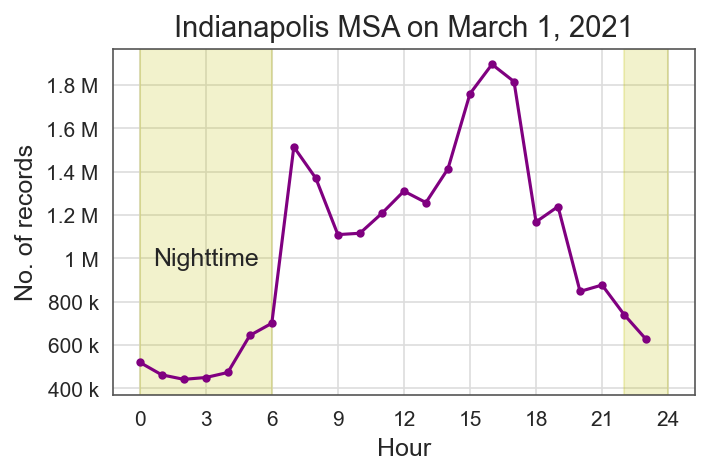

In [15]:
ax = U.plot(size=(5, 3), dpi=150, yeng=1, ylab='No. of records', gridcolor='#ddd',
            title='Indianapolis MSA on March 1, 2021', framebordercolor='#555')
x.set_index('hr').sort_index()['count'].plot(ax=ax, marker='.', color='purple')
ax.axvspan(0, 6, color='y', alpha=0.2)
ax.axvspan(22, 24, color='y', alpha=0.2)
ax.text(3, 1e6, 'Nighttime', ha='center', va='center', fontsize=12)
ax.set_xticks(np.arange(0, 25, 3))
ax.set_xlabel('Hour')
P.imsave(title='Hourly ping count profile in Indianapolis')

### Data summary

In [21]:
res = []
for rgn in tqdm([indy, aus, hous]):
    df = rgn.counts.join(SP.pdf2sdf(Pdf({'date': rgn.dates})), on='date')
    nUsers = df.select(F.col(UID)).toPandas()[UID].nunique() // 1e3
    nPings = df.agg(F.sum('n_pings')).collect()[0][0] // 1e6
    res.append({'City': rgn.name, 'Dates': f'{rgn.dates[0]} - {rgn.dates[-1]}',
                'No. of users (k)': int(nUsers), 'No. of pings (M)': int(nPings)})
Pdf(res)

  0%|          | 0/3 [00:00<?, ?it/s]

,City,Dates,No. of users (k),No. of pings (M)
0,Indianapolis,2021-03-01 - 2021-03-07,608,194
1,Austin,2021-07-01 - 2021-07-07,822,147
2,Houston,2021-07-01 - 2021-07-07,1975,477


## Data quality-quantity tradeoff matrix

### Specify dates of interest

In [22]:
indy.dates = U.dates('2021-03-01', '2021-03-07')
aus.dates = U.dates('2021-07-01', '2021-07-07')
hous.dates = U.dates('2021-07-01', '2021-07-07')

### Prepare tradeoff matrix

In [28]:
indy.counts

DataFrame[uid: bigint, date: date, slot: int, n_pings: int]

In [40]:
def get_quality_quantity_tradeoff_matrix(rgn, save=False):
    dates = SP.pdf2sdf(Pdf({'date': rgn.dates}))
    df = rgn.counts.join(dates, on='date')
    user_pings = df.groupby(UID).agg(F.sum('n_pings').alias('n_pings'))
    df = df.groupby(UID, 'date').count()
    df = df.select(UID, 'date', F.col('count').cast(T.int).alias('n_slots'))
    df = df.groupby(UID, 'n_slots').count().sort(F.col('n_slots').desc())
    df = df.select(UID, 'n_slots', F.col('count').cast(T.int).alias('n_days'))
    df = df.withColumn('cells', F.udf(
        lambda slots, days: list(it.product(range(slots), range(days))), 
        T.array(T.array(T.int16)))('n_slots', 'n_days'))
    df = df.groupby(UID).agg(F.array_distinct(F.flatten(
        F.collect_list('cells'))).alias('cells'))
    df = user_pings.join(df, on=UID)
    df = df.select(UID, 'n_pings', F.explode('cells').alias('cell'))
    df = df.groupby('cell').agg(F.countDistinct(UID).alias('n_users'),
                                F.sum('n_pings').alias('n_pings'))
    df = df.select(df.cell[0].alias('n_slots'), df.cell[1].alias('n_days'),
                   'n_users', 'n_pings').sort('n_slots', 'n_days')
    if save:
        mk.spark.write(df, rgn.data / f'stats/qq_tradeoff_matrix')
    return df

In [42]:
# %time x = get_quality_quantity_tradeoff_matrix(indy, save=True) # t=18s
# %time x = get_quality_quantity_tradeoff_matrix(aus, save=True) # t=7s
# %time x = get_quality_quantity_tradeoff_matrix(hous, save=True) # t=14s

### Plot tradeoff matrix

In [67]:
def plot_quality_quantity_tradeoff_matrix(
    rgn, slot_interval=3, day_interval=1, max_day=None, max_slot=None,
    size=(12, 2), dpi=120, cmap='Greens', annot_size=8
):
    df = pd.read_parquet(rgn.data / f'stats/qq_tradeoff_matrix')
    tot_users, tot_pings = df.iloc[0]['n_users'], df.iloc[0]['n_pings']
    fig, axs = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for ax, var in zip(axs, ['users', 'pings']):
        total = df.iloc[0]['n_'+var]
        mat = df.pivot(index='n_days', columns='n_slots', values='n_'+var)
        mat = (mat.fillna(0) / total) * 100
        mat = mat.loc[:max_day:day_interval, :max_slot:slot_interval]
        g = sns.heatmap(ax=ax, data=mat, cmap=cmap, annot=True,
                        fmt='.0f', annot_kws=dict(fontsize=annot_size))
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set_yticklabels(g.get_yticklabels(), rotation=0)
        ax = U.plot(ax, title='Percent of total {} ($n=${:,.1f}M) filtered'
                    .format(var, total/1e6),
                    xlab='No. of ½-hr bins', ylab='No. of days')
    plt.subplots_adjust(wspace=0.03)
    P.imsave(title=f'Data quality-quantity tradeoff matrix for {rgn.name}')

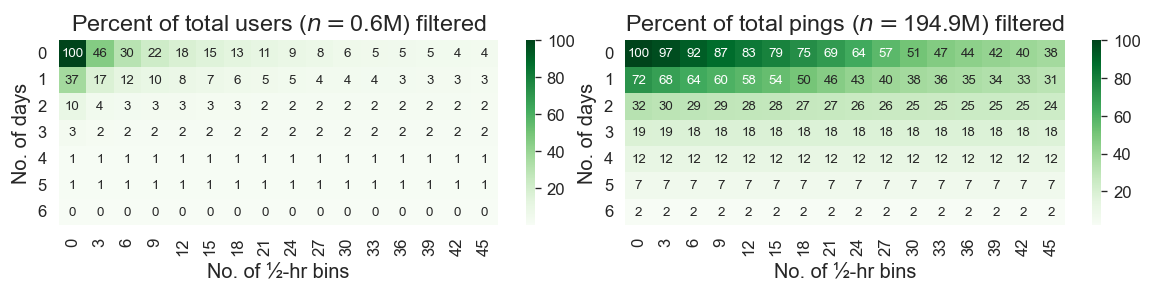

In [68]:
plot_quality_quantity_tradeoff_matrix(indy)

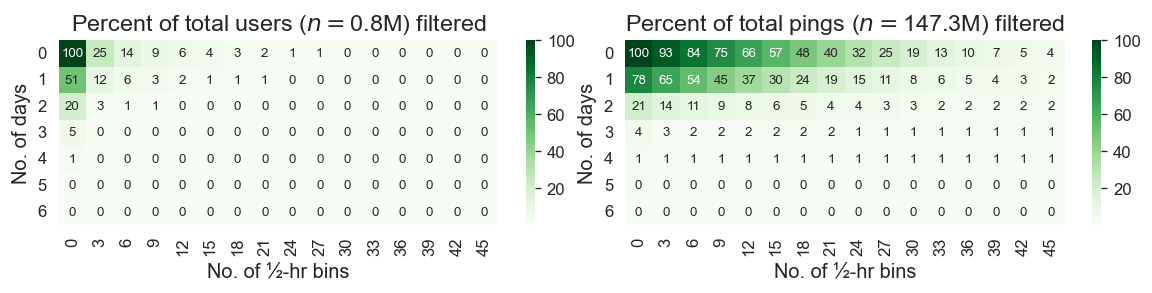

In [69]:
plot_quality_quantity_tradeoff_matrix(aus, cmap='Greens')

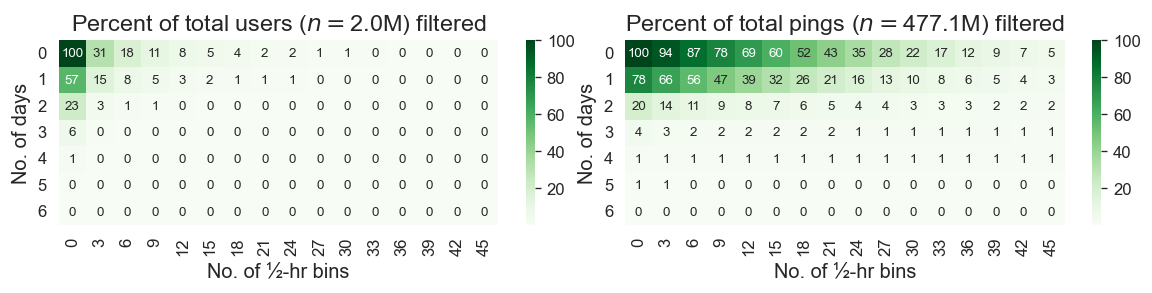

In [70]:
plot_quality_quantity_tradeoff_matrix(hous)

### Figure: Data quality-quantity tradeoff matrix

CPU times: user 4 s, sys: 271 ms, total: 4.27 s
Wall time: 3.79 s


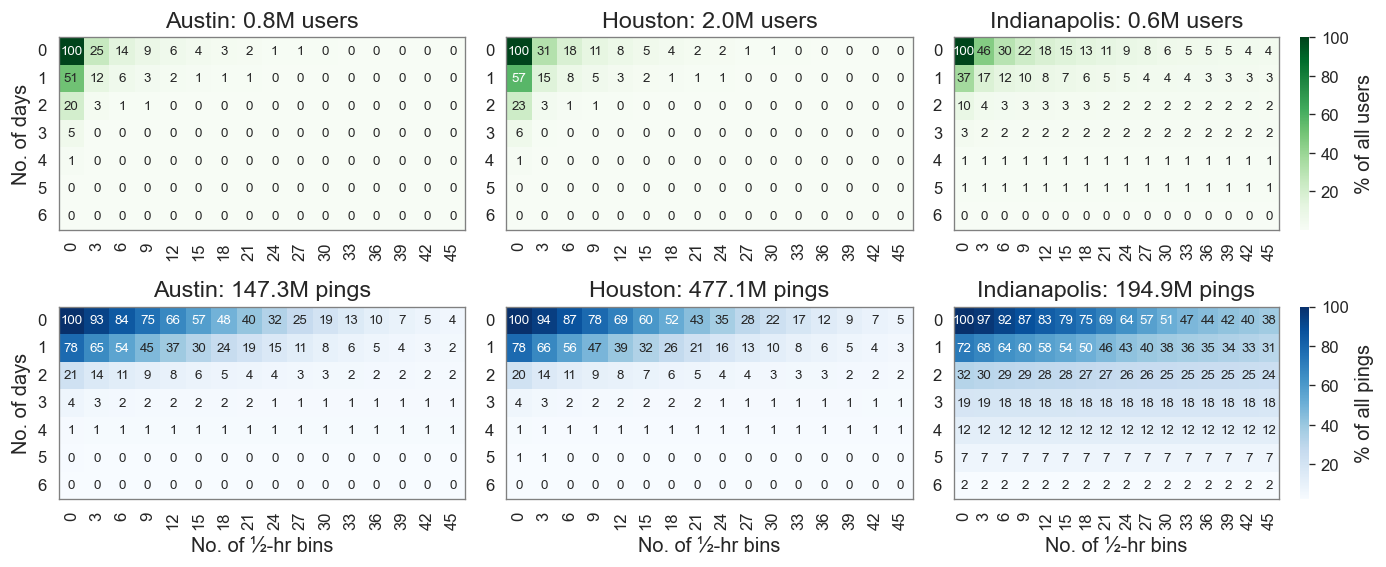

In [99]:
def fig_tradeoff_matrix(slot_interval=3, day_interval=1):
    fig, axs = plt.subplots(2, 3, figsize=(14, 5), dpi=120)
    for j, rgn in enumerate([aus, hous, indy]):
        df = pd.read_parquet(rgn.data / f'stats/qq_tradeoff_matrix')
        tot_users, tot_pings = df.iloc[0]['n_users'], df.iloc[0]['n_pings']
        for i, (var, cmap) in enumerate([('users', 'Greens'), ('pings', 'Blues')]):
            total = df.iloc[0]['n_'+var]
            ax = U.plot(axs[i, j])
            mat = df.pivot(index='n_days', columns='n_slots', values='n_'+var)
            mat = (mat.fillna(0) / total) * 100
            mat = mat.loc[::day_interval, ::slot_interval]
            g = sns.heatmap(ax=ax, data=mat, cmap=cmap, annot=True,
                            fmt='.0f', annot_kws=dict(fontsize=8),
                            cbar=j == 2, cbar_kws=dict(label=f'% of all {var}'))
            g.set_xticklabels(g.get_xticklabels(), rotation=90)
            g.set_yticklabels(g.get_yticklabels(), rotation=0)
            ax = U.plot(ax, title=f'{rgn.name}: {total/1e6:,.1f}M {var}',
                        xlab='No. of ½-hr bins' if i == 1 else None,
                        ylab='No. of days' if j == 0 else None,
                        framebordercolor='grey')
            for spine in ax.spines.values(): spine.set_visible(True)
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    P.imsave(title=f'Data quality-quantity tradeoff matrices')
    
%time x = fig_tradeoff_matrix(); x

# Prepare night pings

## Parameters

In [40]:
# this parameter set means filtering nighttime data of users whose overall 
# nighttime data includes more than a minimum no. of pings
day_hrs = (6, 21) # 6 AM - 9 PM
min_pings = 20 # min pings for a user to be considered during the entire study period
# duration of slot (in seconds) for superping creation
slot_size = 1800 # 30 minutes

P.params.set({'pings': {'day_hours': dict(zip(['start', 'end'], day_hrs)),
                        'slot_size': slot_size, 'nighttime': {'min_pings': min_pings}}})

## Make pings
Filter all the pings only during the nighttime.

In [43]:
def get_nighttime_pings(rgn, day_hrs, min_pings, slot_size, filt_dates=True, save=False):
    dates = rgn.dates if filt_dates else pd.to_datetime(
        [x.stem for x in (rgn.data / 'pings').glob('*')]).date
    df = mk.gps.get_home_work_loc_data(
        SP, dates, root=rgn.data / 'pings',
        day_hrs=day_hrs, min_pings=min_pings)
    df = df.withColumn('slot', F.udf(lambda ts: [int(t / slot_size) for t in ts],
                                     T.array(T.int8))(TS)).drop(TS)
    if save:
        mk.spark.write(df, rgn.data / 'night_pings')
    return df

get_nighttime_pings(indy, day_hrs, min_pings, slot_size)

DataFrame[uid: bigint, day: smallint, lon: array<float>, lat: array<float>, slot: array<tinyint>]

In [ ]:
# %time _ = get_nighttime_pings(indy, day_hrs, min_pings, save=True) # t=1:57
# %time _ = get_nighttime_pings(aus, day_hrs, min_pings, save=True) # t=1:43
# %time _ = get_nighttime_pings(hous, day_hrs, min_pings, save=True) # t=4:51

## Make superpings
From the nighttime pings data, find the mean location and radius of gyration of each super-ping (collection of pings in each ½-hour slot).

**Radius of gyration** (taken from https://doi.org/10.1016/j.comnet.2014.02.011):

$$ r_g = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\vec{p}_i - \vec{p}_{centroid})^2} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} [(x_i - x_c)^2 + (y_i - y_c)^2]} = \sqrt{\text{var}(x) + \text{var}(y)} $$

In [45]:
def dist_deg2m(angle, lat, a=6_371_001, b=6_356_752):
    """ Convert angular distance from degrees to meters at given latitude. """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
        (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(curve_radius * np.deg2rad(angle))

In [46]:
def get_nighttime_superpings(rgn, save=False):
    xyt_cols = [LON, LAT, 'slot']
    df = SP.read_parquet(rgn.data / 'night_pings')
    df = df.select(UID, 'day', F.arrays_zip(*xyt_cols).alias('xyt'))
    df = df.select(UID, 'day', F.explode('xyt').alias('xyt'))
    df = df.select(UID, 'day', *[F.col('xyt')[x].alias(x) for x in xyt_cols])
    df = df.groupby(UID, 'day', 'slot').agg(
        *[F.collect_list(x).alias(x) for x in [LON, LAT]],
        *[F.mean(x).cast(T.float).alias('mean_' + x) for x in [LON, LAT]])
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def get_rg(x, y):
        return dist_deg2m(np.sqrt(np.std(x)**2 + np.std(y)**2), np.mean(y))
    df = df.withColumn('rg', F.udf(get_rg, T.float)(LON, LAT))
    df = df.select(UID, 'day', 'slot', 'n_pings', 'mean_'+LON, 'mean_'+LAT, 'rg')
    if save:
        mk.spark.write(df, rgn.data / 'night_superpings')
    return df
    
get_nighttime_superpings(indy)

DataFrame[uid: bigint, day: smallint, slot: tinyint, n_pings: smallint, mean_lon: float, mean_lat: float, rg: float]

In [ ]:
# %time _ = get_nighttime_superpings(indy, save=True) # t=21s
# %time _ = get_nighttime_superpings(aus, save=True) # t=9s
# %time _ = get_nighttime_superpings(hous, save=True) # t=24s

# Investigate

In [47]:
df = pd.read_parquet(indy.data / 'night_superpings').disp()

4,204,854 rows x 7 cols; Memory: 100.3 MiB


,uid,day,slot,n_pings,mean_lon,mean_lat,rg
,<int64>,<int16>,<int8>,<int16>,<float32>,<float32>,<float32>
0,-9223273625461784742,1,6,2,-85.911194,39.874294,0.598843


<AxesSubplot: >

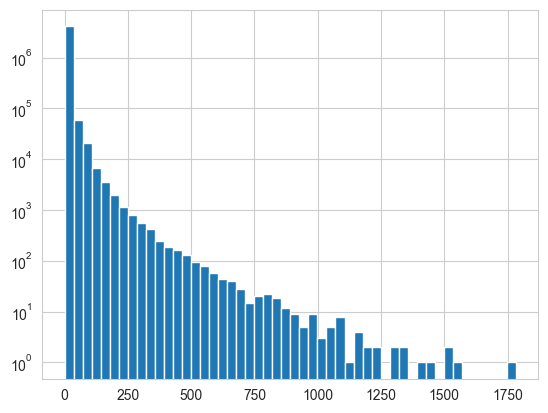

In [48]:
df.n_pings.hist(bins=50, ax=U.plot(ylog=1))

<AxesSubplot: >

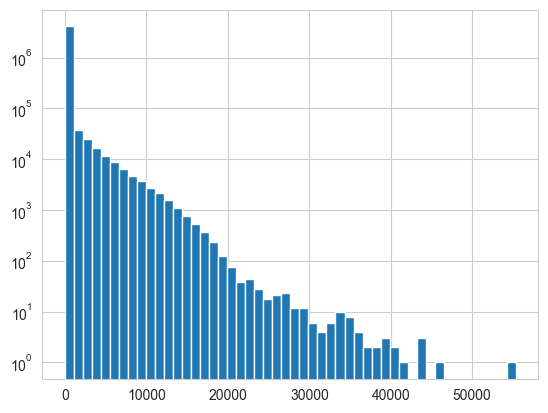

In [49]:
df.rg.hist(bins=50, ax=U.plot(ylog=1))

<AxesSubplot: >

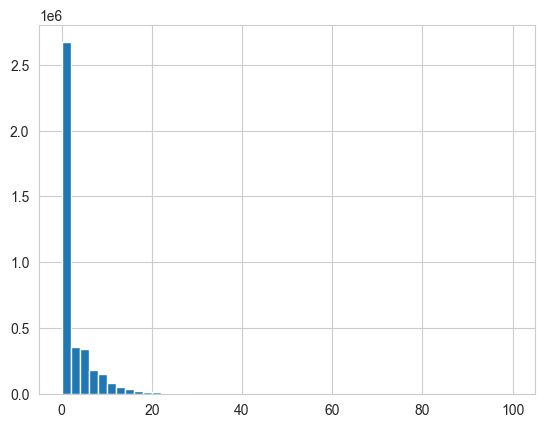

In [50]:
df.rg[df.rg < 100].hist(bins=50)

In [51]:
df.rg.max()

55360.26

In [52]:
df.slot.value_counts().sort_index()

0     239193
1     232914
2     231257
3     225553
4     226054
5     221403
6     221849
7     217973
8     219644
9     216989
10    223122
11    223708
12       722
42    260738
43    256140
44    257143
45    247839
46    241820
47    240793
Name: slot, dtype: int64

In [53]:
df.query('rg > 40000').sort_values('n_pings', ascending=False)

,uid,day,slot,n_pings,mean_lon,mean_lat,rg
3856137,3330900054778122638,3,11,88,-86.212730,39.774864,40655.707031
323157,-7783066272687254180,7,11,9,-85.963745,40.044106,41914.625000
1090950,-2403877343469132506,0,45,6,-86.143120,39.790443,43641.628906
523157,8693264680052732958,7,11,4,-86.196182,39.843384,55360.261719
3927855,-2403877343469132506,0,44,4,-86.029648,39.870731,46289.093750
101811,8711874080805320121,3,44,2,-86.304062,39.998779,43871.750000
309485,8223639275868130404,7,11,2,-86.048126,39.798103,40863.789062
1372852,-8232702994307703476,5,42,2,-86.102524,39.891891,44160.917969


In [54]:
x = SP.read_parquet(indy.data / 'pings/2021-03-04').filter('uid==3330900054778122638').toPandas().iloc[0]; x

uid                                    3330900054778122638
lon      [-85.62567, -85.62568, -85.62532, -85.62532, -...
lat      [39.56968, 39.56967, 39.5696, 39.5696, 39.5696...
ts       [339.0, 349.0, 1475.0, 1476.0, 1480.0, 1486.0,...
error    [13.8, 13.8, 20.2, 24.5, 20.2, 24.5, 19.4, 19....
Name: 0, dtype: object

In [55]:
import contextily as ctx

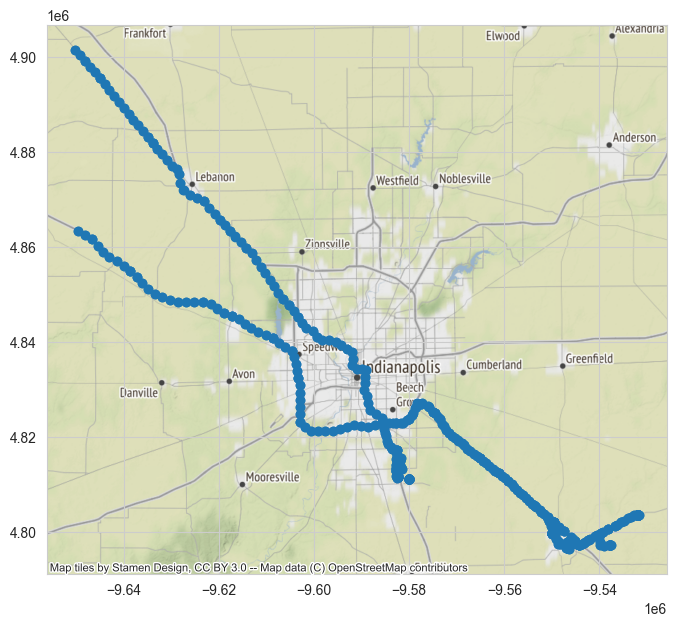

In [56]:
ax = U.plot(size=(8, 8), dpi=100)
mk.geo.pdf2gdf(Pdf({'x':x.lon,'y':x.lat}),'x','y',CRS_DEG).to_crs(CRS_M).plot(ax=ax)
ctx.add_basemap(ax=ax, crs=CRS_M);

In [57]:
df.day.value_counts()

1    618462
4    608768
5    601127
2    594454
3    590181
6    579457
7    391609
0    220796
Name: day, dtype: int64

23/03/09 17:40:19 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-66c2f596-f90d-466f-9167-a1d65f857239. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-66c2f596-f90d-466f-9167-a1d65f857239
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1206)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:374)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:370)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach